In [1]:
# importing the requisite lbraries and setting some parameters
import pandas as pd
import json
import requests
import numpy as np
import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import warnings
warnings.filterwarnings('ignore')

# set the Day_0 and Day_n and calculate the duration
day0 = "2020-02-01"
till_date = "2020-04-16"
tot_days = (date.today() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
print("Data available for " + str(tot_days) + " days.")

# setup the Figure rcParameters
SMALL_SIZE = 9
MEDIUM_SIZE = 11
BIGGER_SIZE = 12
plt.rc("font", size = MEDIUM_SIZE)
plt.rc("axes", titlesize = MEDIUM_SIZE)
plt.rc("axes", labelsize = MEDIUM_SIZE)
plt.rc("xtick", labelsize = SMALL_SIZE)
plt.rc("ytick", labelsize = SMALL_SIZE)
plt.rc("legend", fontsize = BIGGER_SIZE)
plt.rc("figure", titlesize = BIGGER_SIZE)

Data available for 75 days.


In [2]:
# read the API
api_data_raw = requests.get("https://api.covid19india.org/raw_data.json").json()
head = list(api_data_raw["raw_data"][0].keys())

In [3]:
# making an empty dataframe to which the data from the API is added
temp = pd.DataFrame()
for i in api_data_raw["raw_data"]:
    api_data = pd.DataFrame([i.values()], columns = head)
    temp = temp.append(api_data, ignore_index = True)

# remove empty data rows
temp1 = list(temp.loc[0: len(api_data_raw["raw_data"]), "currentstatus"])
non_empty_temp = [i for i, item in enumerate(temp1) if item != ""]
api_data_raw = temp[0: len(non_empty_temp)]

# clearing the memory
del head
del temp
del temp1
del non_empty_temp

In [4]:
# finding the printing the total number of and nationalities of corona virus patients in India
unique_nationalities = set(api_data_raw["nationality"].values.tolist())
unique_nationalities = list(unique_nationalities)
unique_nationalities.remove('')
print("There are a total of " + str(len(api_data_raw)) + " corona virus patients in India. They belong to " + str(len(unique_nationalities)) + " different nationalities -", end = " ")
for i in unique_nationalities:
    if i != unique_nationalities[-1]:
        print(i, end = ", ")
    else:
        print(i)

# clearing the memory
del unique_nationalities

There are a total of 12979 corona virus patients in India. They belong to 11 different nationalities - Indonesia, Thailand, Malaysia, Myanmar, India, Canada, United Kingdom, United States of America, Italy, Phillipines, Tibet


In [5]:
# manipulating the API data to get the date column in the correct format
temp1 = list(api_data_raw["dateannounced"])
date_from_temp1 = [datetime.datetime.strptime(x, "%d/%m/%Y") for x in temp1]
temp_data = api_data_raw.copy()
temp_data["dateannounced"] = date_from_temp1
temp1 = pd.to_datetime(temp_data.dateannounced, format = "%Y-%m-%d")
temp_data["dateannounced"] = temp1.dt.strftime("%Y-%m-%d")

# set till_date as the last date available in api_data_raw
date_yesterday = till_date
data_temp = temp_data[(temp_data["dateannounced"] <= date_yesterday)]
data_temp = data_temp.drop(["agebracket", "backupnotes", "contractedfromwhichpatientsuspected", "estimatedonsetdate", "notes", "patientnumber", "source1", "source2", "source3", "statecode", "statepatientnumber", "statuschangedate"], axis = 1)

# clearing the memory
del temp1
del date_from_temp1
del temp_data
del date_yesterday

# Preparing the data for visualization

## Preparing the district wise DataFrame

In [6]:
# preparing the district data
data_district = data_temp.copy()
data_district = data_district.rename({"detecteddistrict": "District"}, axis = "columns")
data_district = data_district.rename({"dateannounced": "Date"}, axis = "columns")

data_district.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = 'int')
data_district.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = 'int')
data_district.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data_district[data_district["currentstatus"] == "Recovered"]
data_district.loc[list(temp.index), "Recovered"] = 1
temp = data_district[data_district["currentstatus"] == "Fatalities"]
data_district.loc[list(temp.index), "Fatalities"] = 1

temp_data = data_district.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data_district.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

districts = list(data_district.District.unique())
district_data = pd.DataFrame()
for j in range (0, len(districts)):
    st = data_district.query("District == " + '"' + districts[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([districts[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"District": name, "Date": pd.to_datetime(a, format = '%Y-%m-%d'), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    district_data = district_data.append(dd, ignore_index = True)

temp = pd.to_datetime(district_data.Date)
district_data["Date"] = temp.dt.strftime("%Y-%m-%d")

# removing those entries from the district database which don't have the district name
no_district_name = []
for ind, i in district_data.iterrows():
    if i["District"] == "":
        no_district_name.append(ind)
district_data = district_data.drop(no_district_name)

# clearing the memory
del temp
del temp_data
del temp2
del districts
del data_district
del no_district_name

## Preparing the state wise DataFrame

In [7]:
# preparing the state data
data = data_temp.copy()
data = data.rename({"detectedstate": "State"}, axis = "columns")
data = data.rename({"dateannounced": "Date"}, axis = "columns")

data.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data[data["currentstatus"] == "Recovered"]
data.loc[list(temp.index), "Recovered"] = 1
temp = data[data["currentstatus"] == "Fatalities"]
data.loc[list(temp.index), "Fatalities"] = 1

temp_data = data.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

states = list(data.State.unique())
state_data = pd.DataFrame()

for j in range (0, len(states)):
    st = data.query("State == " +  '"' + states[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([states[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"State": name, "Date": pd.to_datetime(a, format = "%Y-%m-%d"), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    state_data = state_data.append(dd, ignore_index = True)

temp = pd.to_datetime(state_data.Date)
state_data["Date"] = temp.dt.strftime("%Y-%m-%d")

# removing those entries from the state database which don't have the state name
no_state_name = []
for ind, i in state_data.iterrows():
    if i["State"] == "":
        no_state_name.append(ind)
state_data = state_data.drop(no_state_name)

# clearing the memory
del temp
del temp_data
del temp2
del data
del states
del no_state_name

# State and district wise data visualisation

## State wise growth of cases

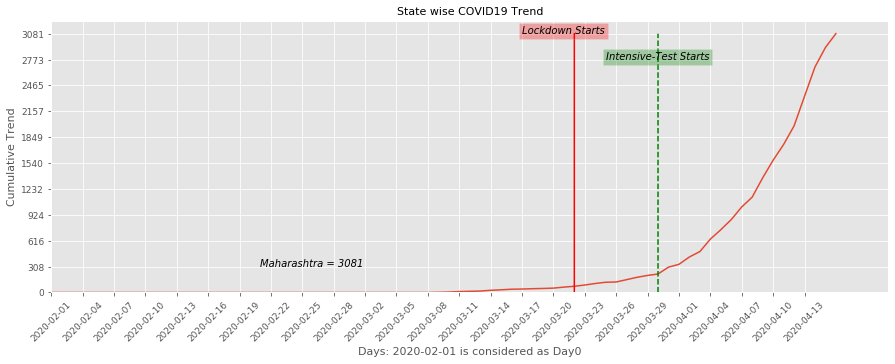

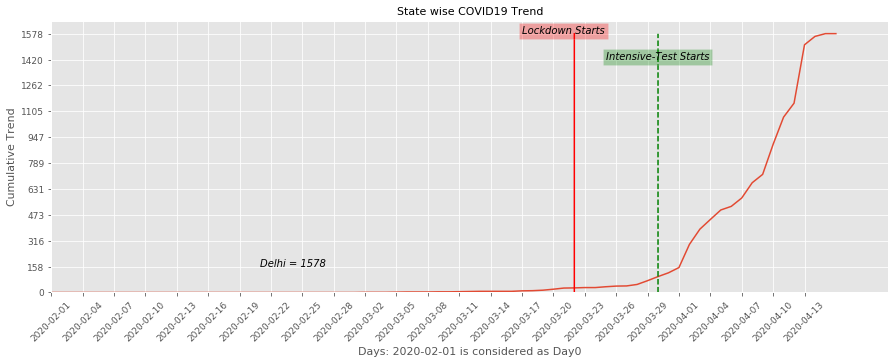

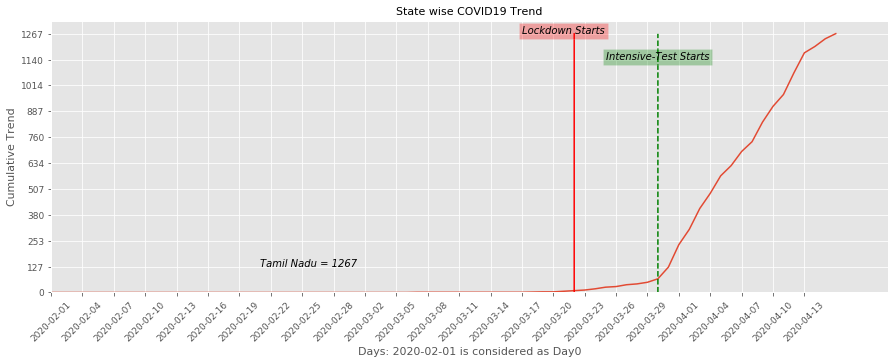

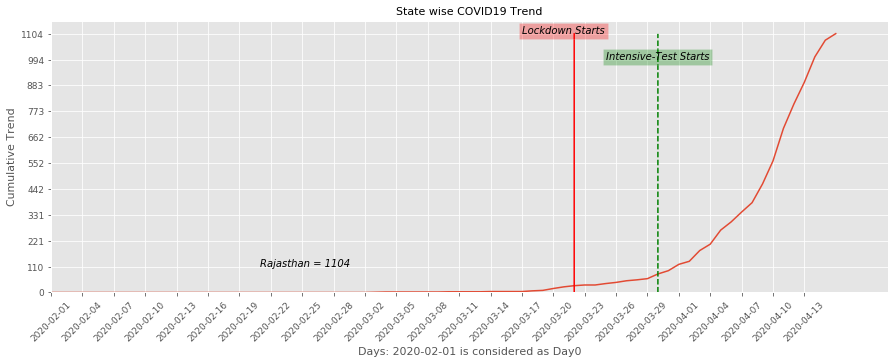

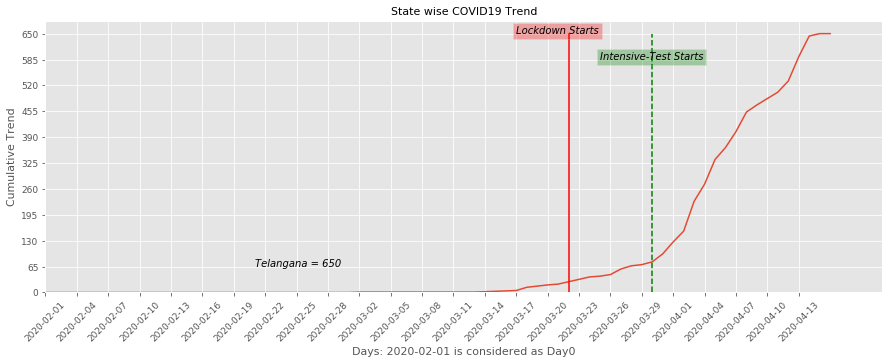

In [8]:
# plotting the infection data for the states with the most patients
no_states = 5
xloc = 20

train_state = state_data
states = list(train_state.State.unique())
gb = pd.DataFrame(train_state.groupby(["State"])["ConfirmedCases"].agg("sum"))
stsort = gb.sort_values(by = ["ConfirmedCases"], ascending = False)

for j in range (no_states):
    data_for_graph = train_state.query("State == " + '"' + stsort.index[j] + '"')
    tss = data_for_graph.ConfirmedCases
    date = (data_for_graph.Date)
    plt.figure(figsize = (15, 5))
    plt.plot(date, (tss))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days, 3), rotation = 45)
    plt.xlim([0, tot_days + 5])
    plt.ylim(tss.iloc[-1] + 1)
    plt.yticks(np.arange(0, tss.iloc[-1] + 1, tss.iloc[-1] / 10))#, tss.iloc[-1] + 1, tss.iloc[-1] / 10)#100, tss.iloc[-1], 100
    plt.text(xloc, tss.iloc[-1] / 10, str(stsort.index[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("State wise COVID19 Trend")
    
    rangey = np.arange(0, tss.iloc[-1])
    lockday = (datetime.datetime.strptime("2020-03-22", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    intense_day = (datetime.datetime.strptime("2020-03-30", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    plt.plot(np.ones((rangey.size)) * lockday,np.arange(0, tss.iloc[-1]), "r", label = "Lockdown_day")
    plt.text(lockday - 5, tss.iloc[-1], "Lockdown Starts", style = "italic", bbox = {"facecolor": "red", "alpha": 0.3, "pad": 3})
    plt.plot(np.ones((rangey.size)) * intense_day, np.arange(0, tss.iloc[-1]), "g--", label = "Intensive-Test Starts")
    plt.text(intense_day - 5, tss.iloc[-1] - tss.iloc[-1] / 10, "Intensive-Test Starts", style = "italic", bbox = {"facecolor": "green", "alpha": 0.3, "pad": 3})
    plt.show()

# clearing the memory
del train_state
del states
del gb
del stsort
del no_states

## District wise growth of cases

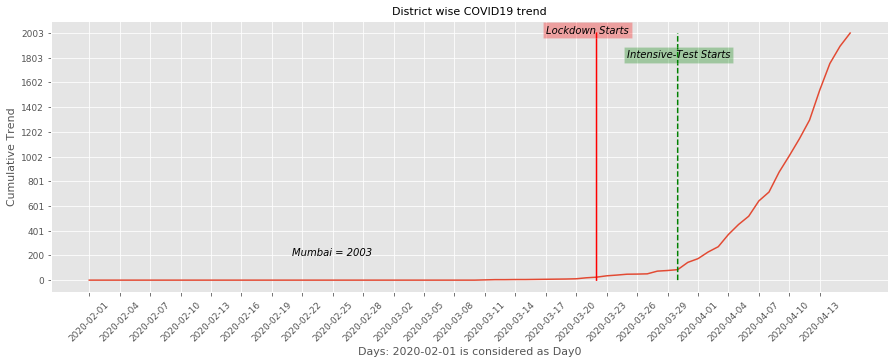

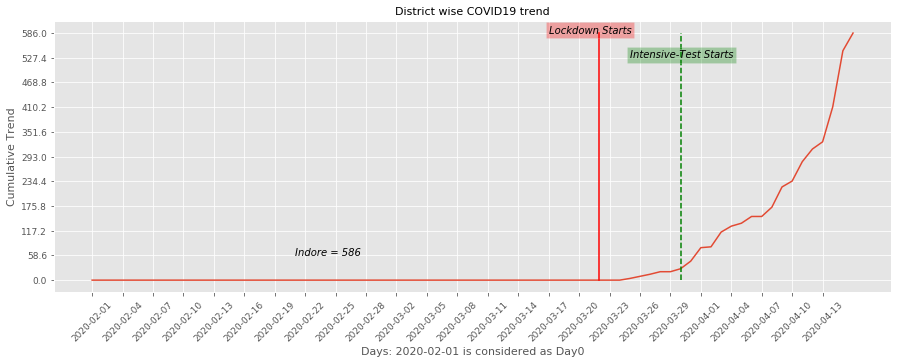

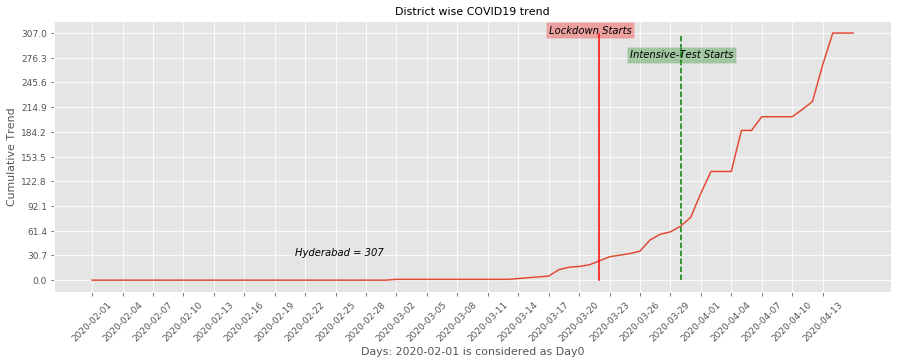

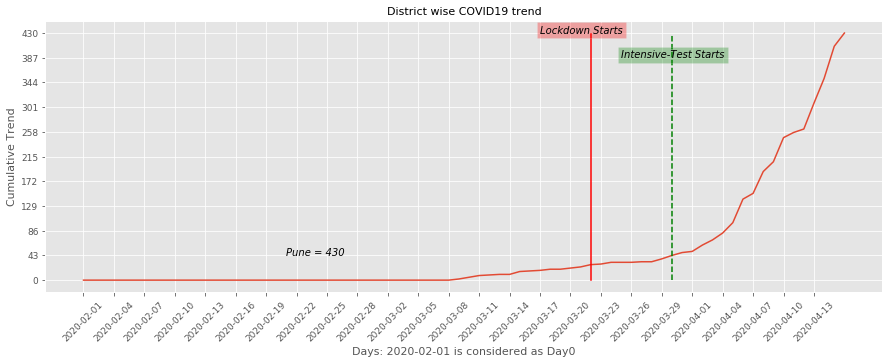

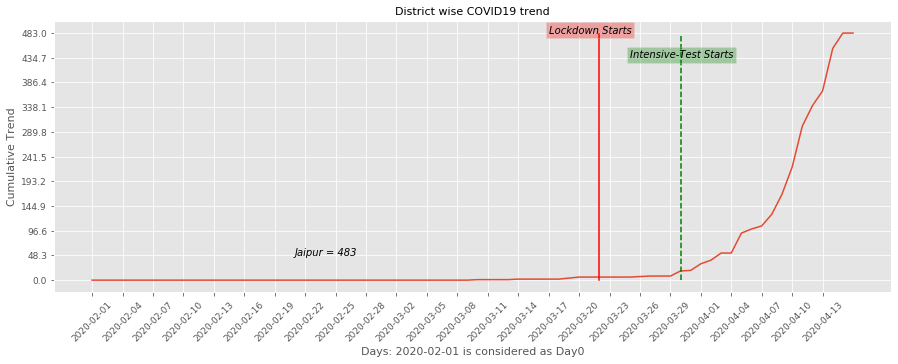

In [9]:
# plotting the infection data for the districts with the most patients
no_districts = 5

train_district = district_data
districts = list(train_district.District.unique())
gb = pd.DataFrame(train_district.groupby(["District"])["ConfirmedCases"].agg("sum"))
stsort = gb.sort_values(by = ["ConfirmedCases"], ascending = False)

for j in range(no_districts):
    data_for_graph = train_district.query("District == " + '"' + stsort.index[j] + '"')
    tss = data_for_graph.ConfirmedCases
    date = (data_for_graph.Date)
    plt.figure(figsize = (15, 5))
    plt.plot(date, (tss))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days, 3), rotation = 45)
    plt.yticks(np.arange(0, tss.iloc[-1] + 1, tss.iloc[-1] / 10))
    plt.text(20,  tss.iloc[-1] / 10, str(stsort.index[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("District wise COVID19 trend")
    
    rangey = np.arange(0, tss.iloc[-1])
    lockday = (datetime.datetime.strptime("2020-03-22", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    intense_day = (datetime.datetime.strptime("2020-03-30", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    plt.plot(np.ones((rangey.size)) * lockday,np.arange(0, tss.iloc[-1]), "r", label = "Lockdown_day")
    plt.text(lockday - 5, tss.iloc[-1], "Lockdown Starts", style = "italic", bbox = {"facecolor": "red", "alpha": 0.3, "pad": 3})
    plt.plot(np.ones((rangey.size)) * intense_day, np.arange(0, tss.iloc[-1]), "g--", label = "Intensive-Test Starts")
    plt.text(intense_day - 5, tss.iloc[-1] - tss.iloc[-1] / 10, "Intensive-Test Starts", style = "italic", bbox = {"facecolor": "green", "alpha": 0.3, "pad": 3})
    plt.show()

# clearing the memory
del train_district
del districts
del gb
del stsort
del no_districts
del data_for_graph

## Overall type of transmission

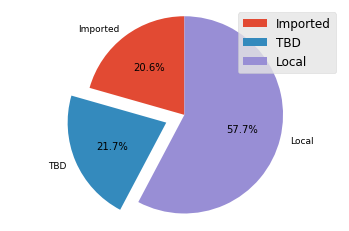

In [10]:
# plotting the overall type of transmission
query = data_temp.query("typeoftransmission == \"Imported\"")
imported = query.loc[:, "typeoftransmission"].count()
query = data_temp.query("typeoftransmission == \"TBD\"")
tbd = query.loc[:, "typeoftransmission"].count()
query = data_temp.query("typeoftransmission == \"Local\"")
local = query.loc[:, "typeoftransmission"].count()
data_for_pie_chart = np.array([imported, tbd, local])
fig1, ax1 = plt.subplots()
ax1.pie(data_for_pie_chart, explode = (0, 0.2, 0), labels = ("Imported", "TBD", "Local"), autopct = "%1.1f%%", startangle = 90)
ax1.axis("equal")
plt.legend()
plt.show()

# clearing the memory
del query
del imported
del tbd
del local
del data_for_pie_chart
del fig1
del ax1

## Types of transmission for some specific states

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


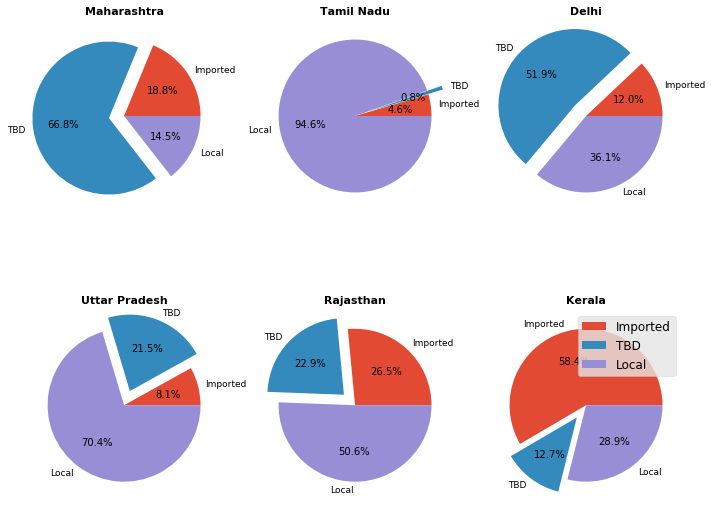

In [11]:
# plotting the type of transmission for some specific states
state = list(["Maharashtra", "Tamil Nadu", "Delhi", "Uttar Pradesh", "Rajasthan", "Kerala"])
count = 0

fig1, ax1 = plt.subplots(2,3, figsize = (10, 12), sharey = True)
for i in range(0, 2):
    for j in range(0, int(len(state) / 2), 1):
        detected_state = data_temp.query("detectedstate == \"" + str(state[count]) + "\"")
        query = detected_state.query("typeoftransmission == \"Imported\"")
        imported = query.loc[:, "typeoftransmission"].count()
        query = detected_state.query("typeoftransmission == \"TBD\"")
        tbd = query.loc[:, "typeoftransmission"].count()
        query = detected_state.query("typeoftransmission == \"Local\"")
        local = query.loc[:, "typeoftransmission"].count()        
        data_for_pie_chart = np.array([imported, tbd, local])
        patches, texts, autotexts = ax1[i,j].pie(data_for_pie_chart, explode = (0, 0.2, 0), labels = ("Imported", "TBD", "Local"), autopct = "%1.1f%%")
        ax1[i,j].set_title(str(state[count]), fontweight = "bold")
        plt.tight_layout()
        plt.legend()
        count += 1

# clearing the memory
del state
del count
del fig1
del ax1
del detected_state
del query
del imported
del tbd
del local
del data_for_pie_chart
del patches
del texts
del autotexts

## Types of transmission for some specific districts

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


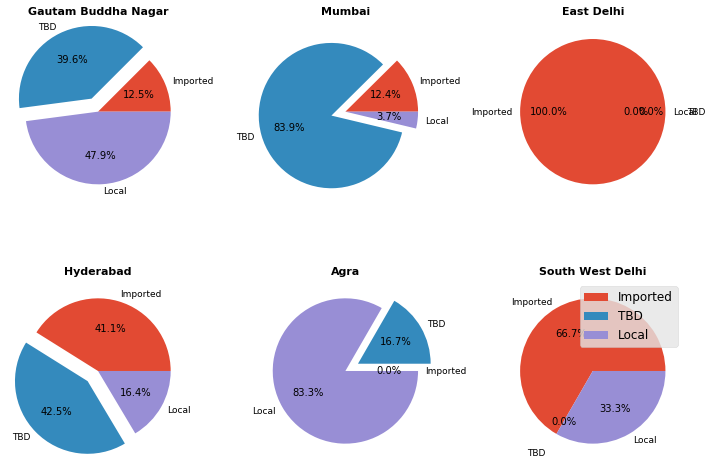

In [12]:
# plotting the type of transmission for some specific districts
district = list(["Gautam Buddha Nagar", "Mumbai", "East Delhi", "Hyderabad", "Agra", "South West Delhi"])
count = 0

fig1, ax1 = plt.subplots(2, 3, figsize = (10, 10), sharey = True)
for i in range(0, 2):
    for j in range(0, int(len(district) / 2), 1):
        detected_district = data_temp.query("detecteddistrict == \"" + str(district[count]) + "\"")
        query = detected_district.query("typeoftransmission == \"Imported\"")
        imported = query.loc[:, "typeoftransmission"].count()
        query = detected_district.query("typeoftransmission == \"TBD\"")
        tbd = query.loc[:, "typeoftransmission"].count()
        query = detected_district.query("typeoftransmission == \"Local\"")
        local = query.loc[:, "typeoftransmission"].count()
        data_for_pie_chart = np.array([imported, tbd, local])
        patches, texts, autotexts = ax1[i,j].pie(data_for_pie_chart, explode = (0, 0.2, 0), labels = ("Imported", "TBD", "Local"), autopct = "%1.1f%%")
        ax1[i, j].set_title(str(district[count]), fontweight = "bold")
        plt.tight_layout()
        plt.legend()
        count += 1

# clearing the memory
del district
del count
del fig1
del ax1
del detected_district
del query
del imported
del tbd
del local
del data_for_pie_chart
del patches
del texts
del autotexts

# Gender breakdown of the patients

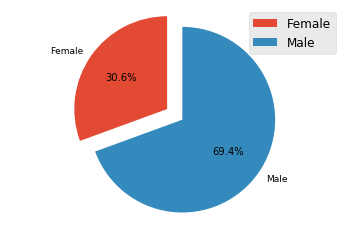

In [13]:
# plotting the overall type of transmission
query = data_temp.query("gender == \"F\"")
f = query.loc[:, "gender"].count()
query = data_temp.query("gender == \"M\"")
m = query.loc[:, "gender"].count()
data_for_pie_chart = np.array([f, m])
fig1, ax1 = plt.subplots()
ax1.pie(data_for_pie_chart, explode = (0, 0.2), labels = ("Female", "Male"), autopct = "%1.1f%%", startangle = 90)
ax1.axis("equal")
plt.legend()
plt.show()

# clearing the memory
del query
del f
del m
del data_for_pie_chart
del fig1
del ax1

# Prediction

## Polynomical Regression

In [14]:
# preparing the state data
data = data_temp.copy()
data = data.rename({"detectedstate": "State"}, axis = "columns")
data = data.rename({"dateannounced": "Date"}, axis = "columns")

data.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data[data["currentstatus"] == "Recovered"]
data.loc[list(temp.index), "Recovered"] = 1
temp = data[data["currentstatus"] == "Fatalities"]
data.loc[list(temp.index), "Fatalities"] = 1

temp_data = data.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

states = list(data.State.unique())
state_data = pd.DataFrame()

for j in range (0, len(states)):
    st = data.query("State == " +  '"' + states[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([states[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"State": name, "Date": pd.to_datetime(a, format = "%Y-%m-%d"), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    state_data = state_data.append(dd, ignore_index = True)

temp = pd.to_datetime(state_data.Date)
state_data["Date"] = temp.dt.strftime("%Y-%m-%d")

# removing those entries from the state database which don't have the state name
no_state_name = []
for ind, i in state_data.iterrows():
    if i["State"] == "":
        no_state_name.append(ind)
state_data = state_data.drop(no_state_name)

# clearing the memory
del temp
del temp_data
del temp2
del data
del states
del no_state_name

In [15]:
# converting "Date" into Datetime format
state_data["Date"] = pd.to_datetime(state_data["Date"])

# grouping the cases by date and state/union territory for easier analysis
state_date = state_data.groupby(["Date", "State"]).agg({"ConfirmedCases": "sum"})

# removing the rows with entries that are not integers
to_remove = []
for idx, i in state_date.iterrows():
    try:
        k = int(i["ConfirmedCases"])
    except:
        to_remove.append(idx)
state_date = state_date.drop(to_remove)

# making the "Date" column part of the database
state_date["Date"] = state_date.index

# making the index column
ind = []
for i in range(len(state_date)):
    ind.append(i)
state_date["Index"] = ind
state_date.set_index("Index", inplace = True)

# making and attaching the date and state/union territory column to the database
date = []
for i in state_date["Date"]:
    date.append(i[0])
state = []
for i in state_date["Date"]:
    state.append(i[1])
state_date["Date"] = date
state_date["State/UnionTerritory"] = state

state_date["Days Since"] = state_date["Date"] - state_date["Date"][0]
state_date["Days Since"] = state_date["Days Since"].dt.days
        
# resetting DataFrame with columns in desired order
state_date = state_date[["Date", "State/UnionTerritory", "Days Since", "ConfirmedCases"]]

# clearing the memory
del to_remove
del ind
del date
del state

Root Mean Square Error for Andaman and Nicobar Islands's Polynomial Regression:  60.10084381506994
Root Mean Square Error for Andhra Pradesh's Polynomial Regression:  193.99507341274912
Root Mean Square Error for Arunachal Pradesh's Polynomial Regression:  0.9682458365518543
Root Mean Square Error for Assam's Polynomial Regression:  24.012708536472367
Root Mean Square Error for Bihar's Polynomial Regression:  54.84383463063466
Root Mean Square Error for Chandigarh's Polynomial Regression:  13.597808252371138
Root Mean Square Error for Chhattisgarh's Polynomial Regression:  18.765469846515945
Root Mean Square Error for Dadra and Nagar Haveli's Polynomial Regression:  0.82915619758885
Root Mean Square Error for Delhi's Polynomial Regression:  500.1468633447048
Root Mean Square Error for Goa's Polynomial Regression:  21.83167409398262
Root Mean Square Error for Gujarat's Polynomial Regression:  211.28621202387572
Root Mean Square Error for Haryana's Polynomial Regression:  44.871386413298

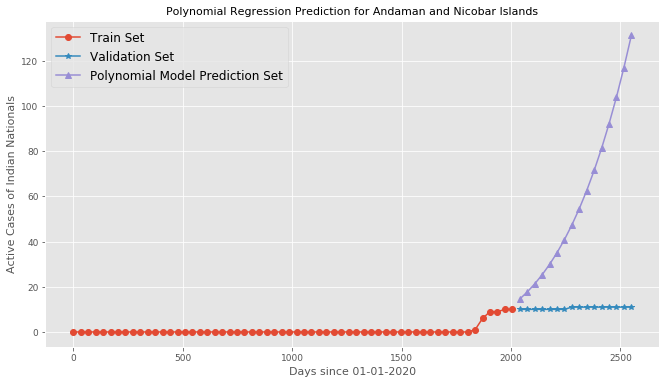

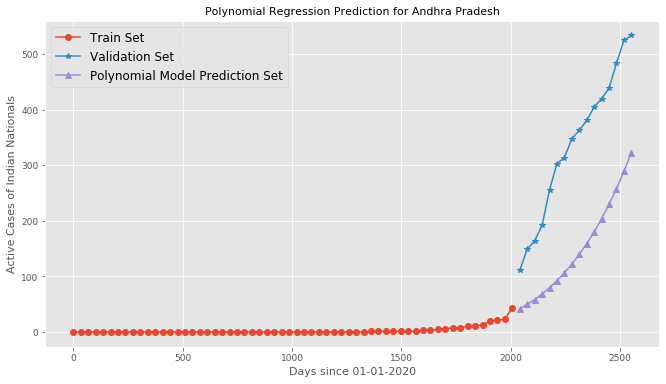

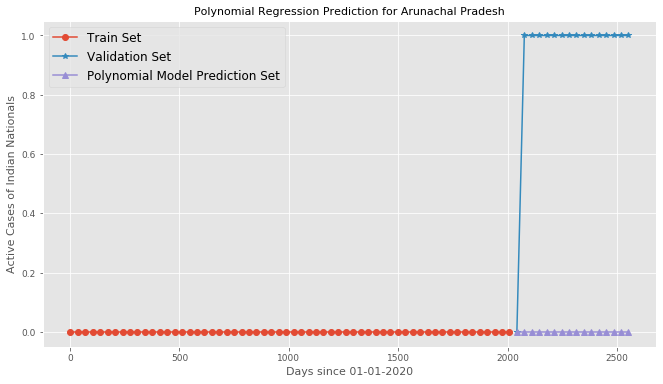

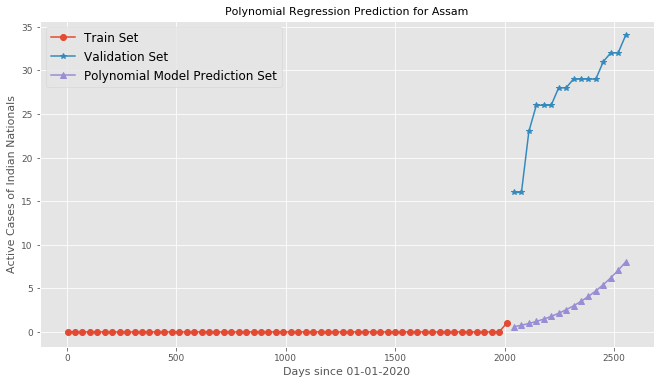

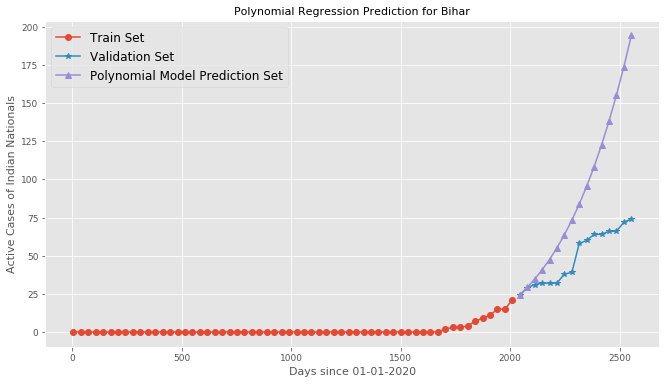

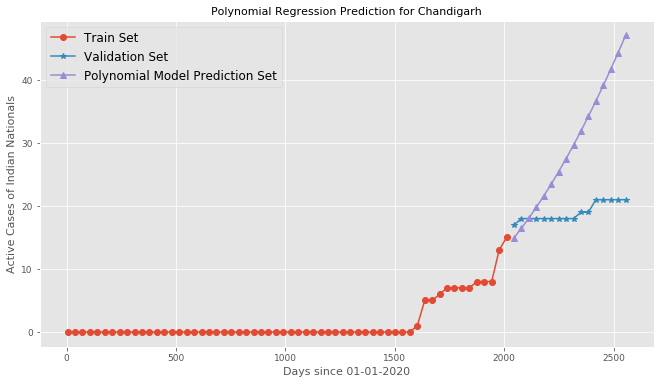

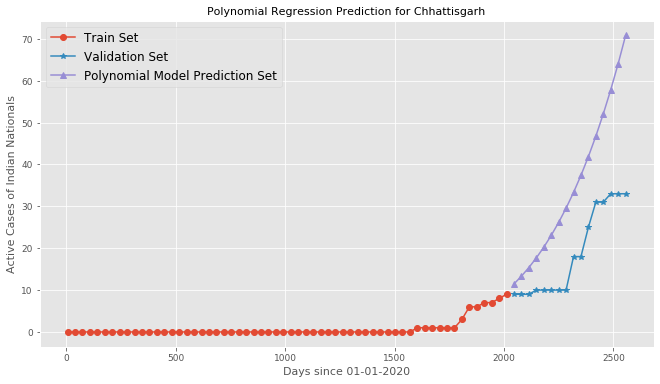

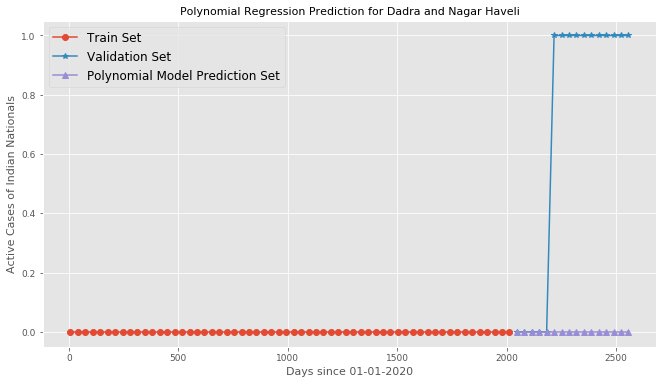

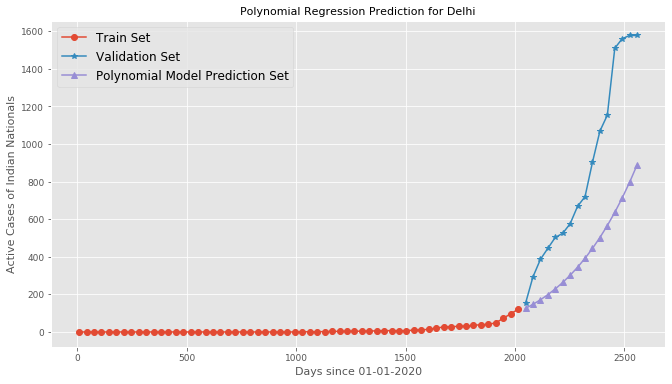

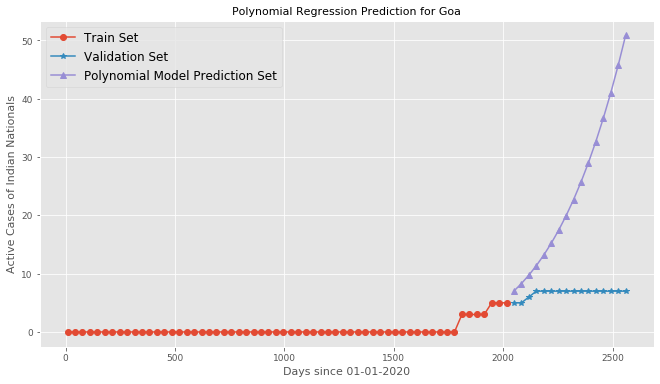

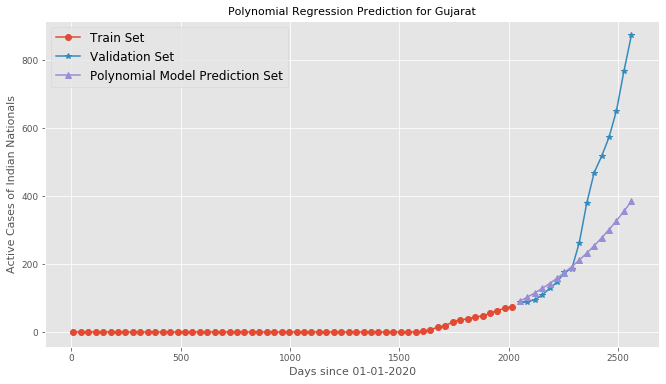

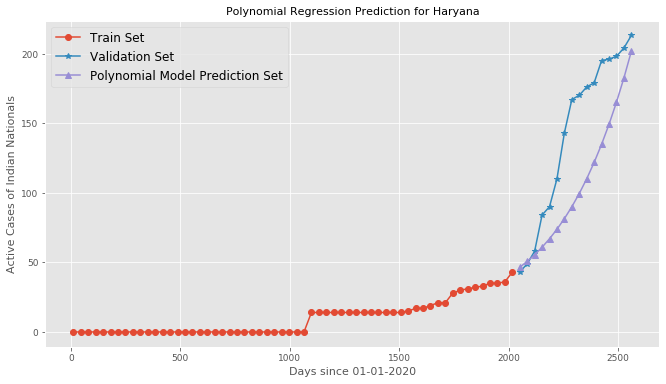

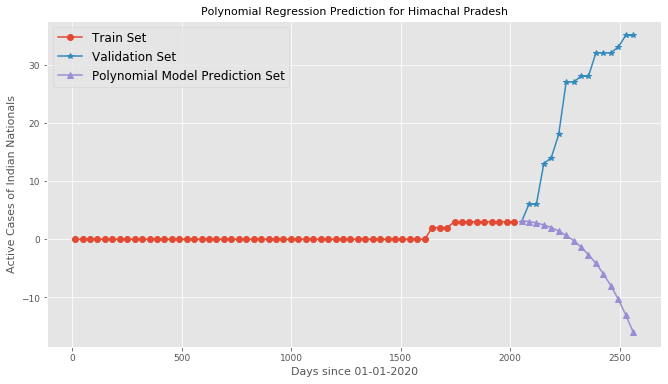

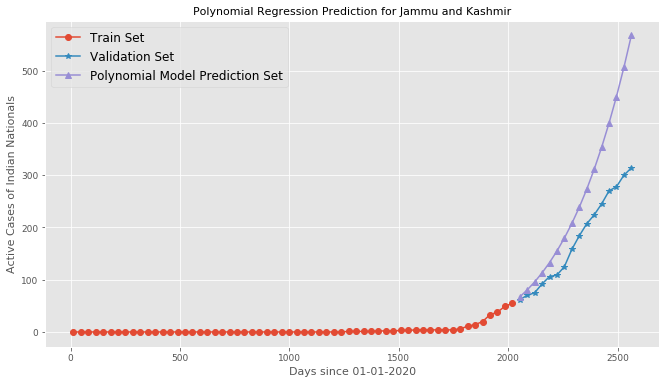

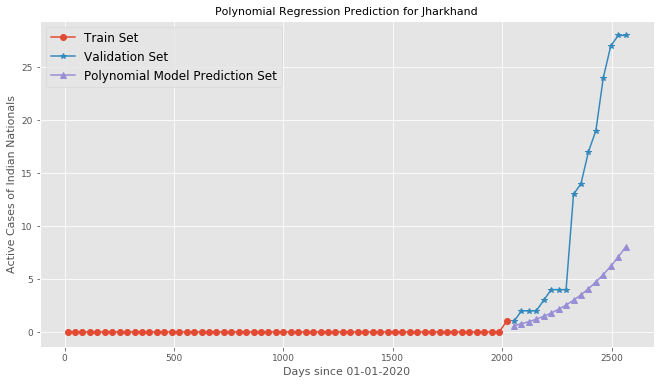

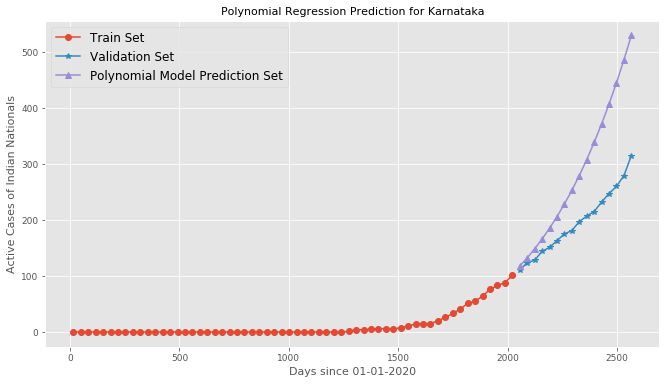

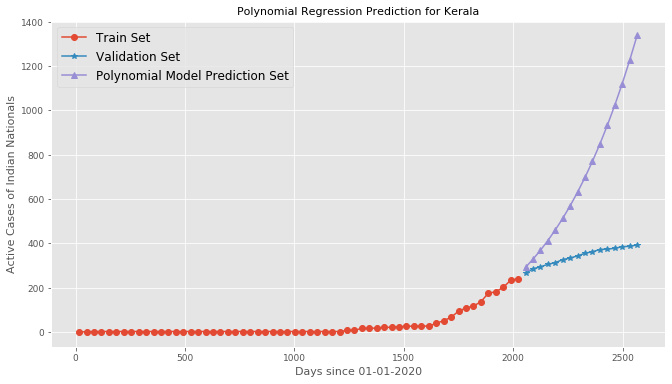

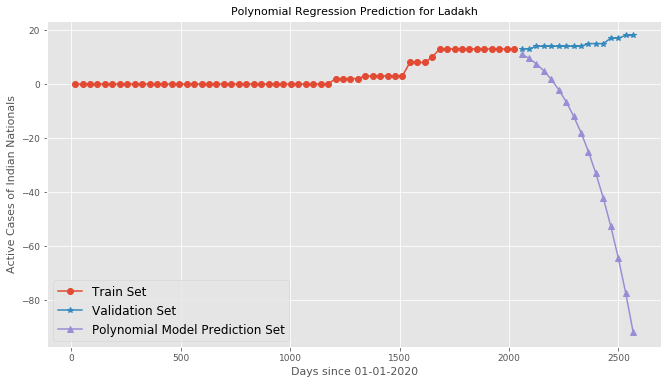

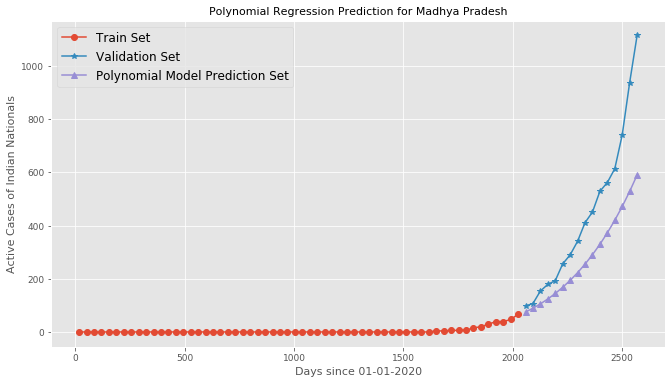

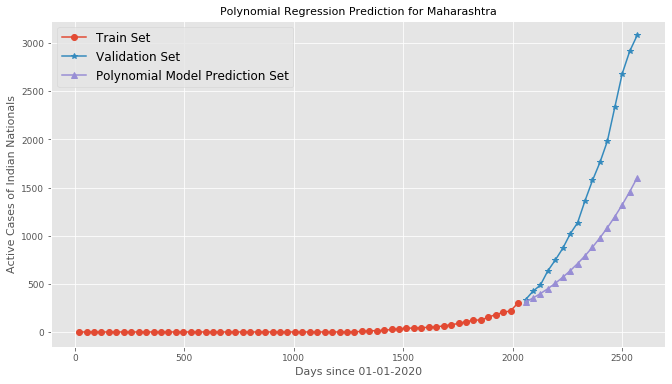

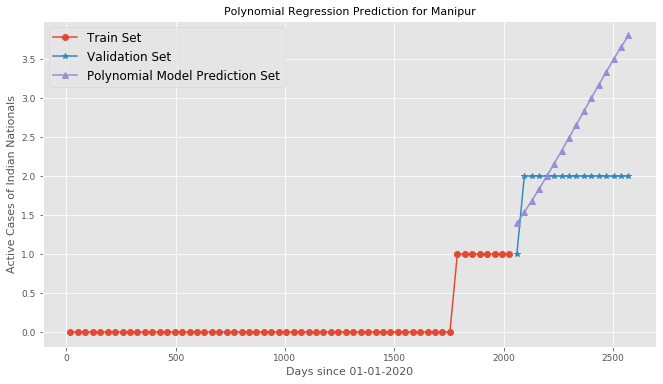

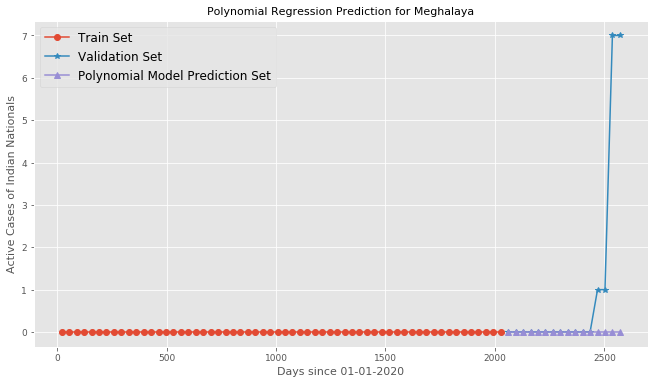

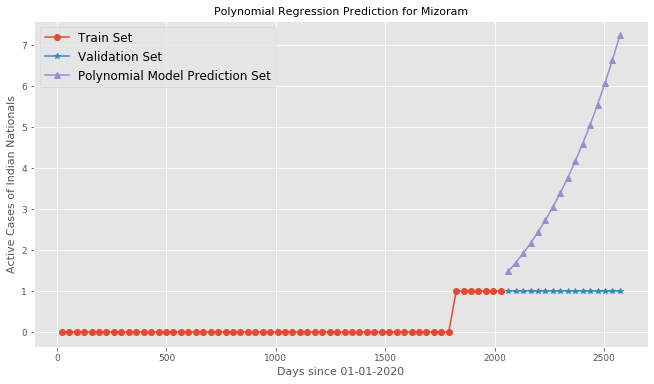

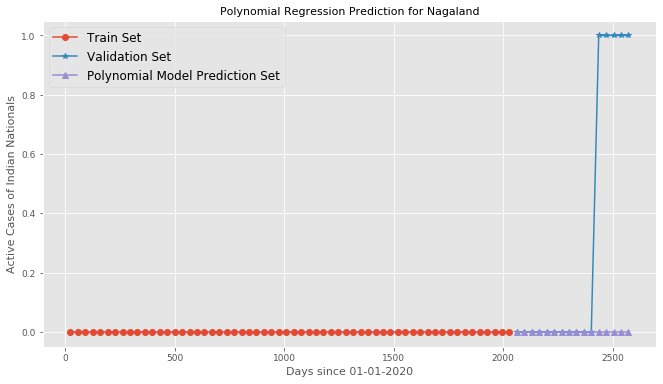

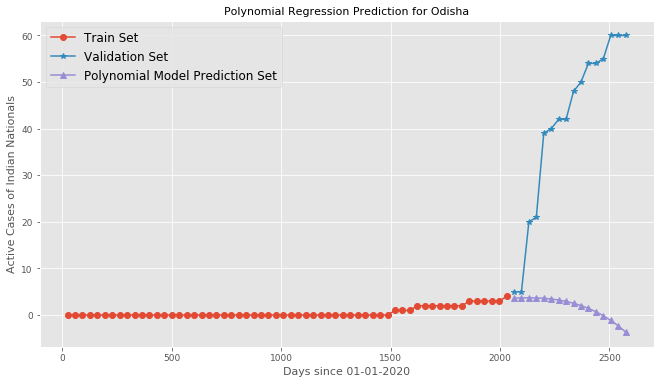

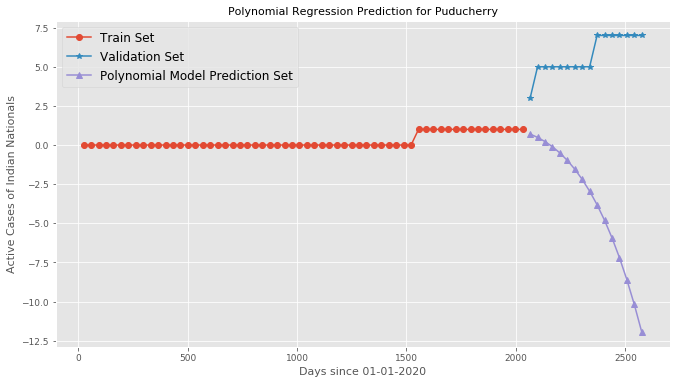

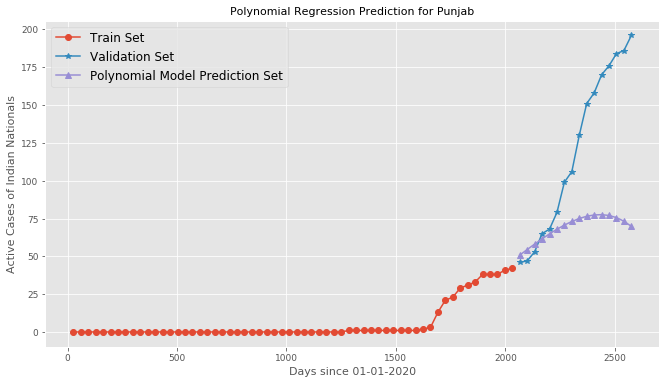

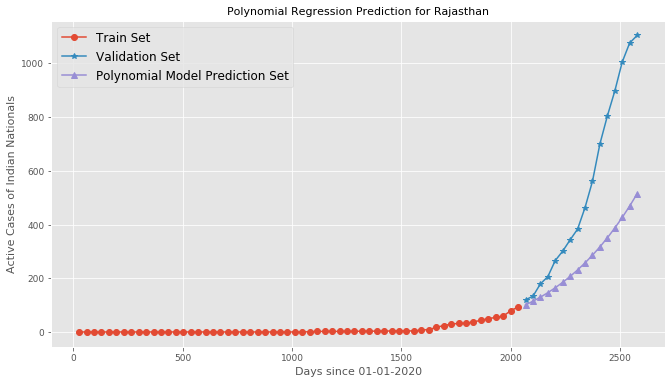

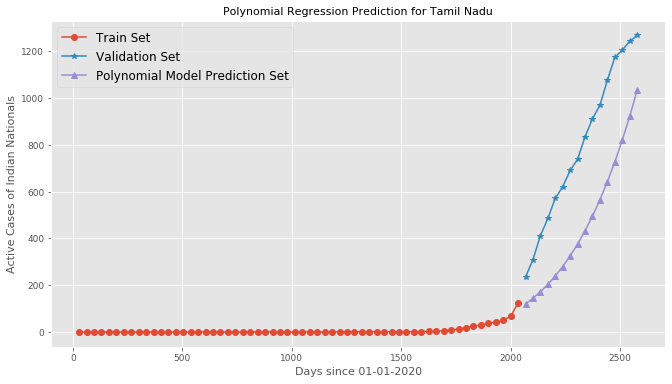

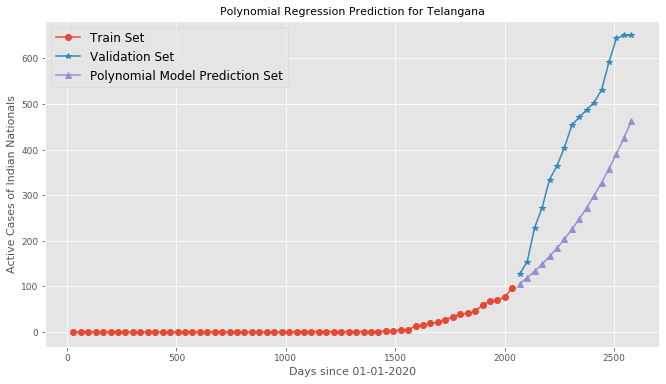

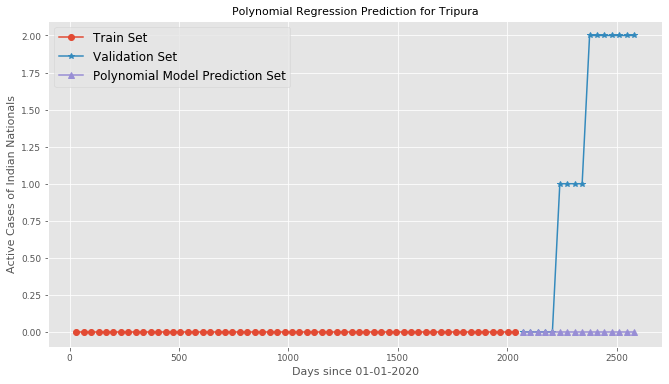

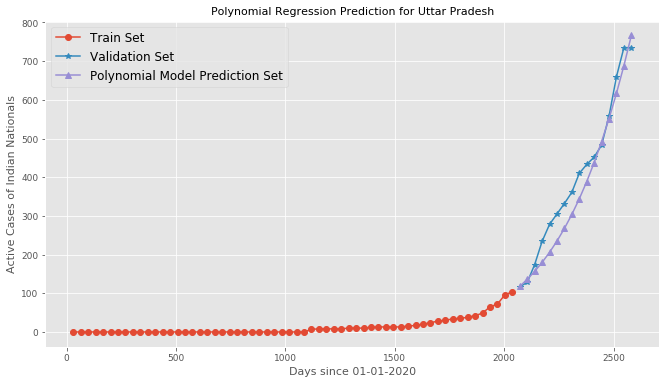

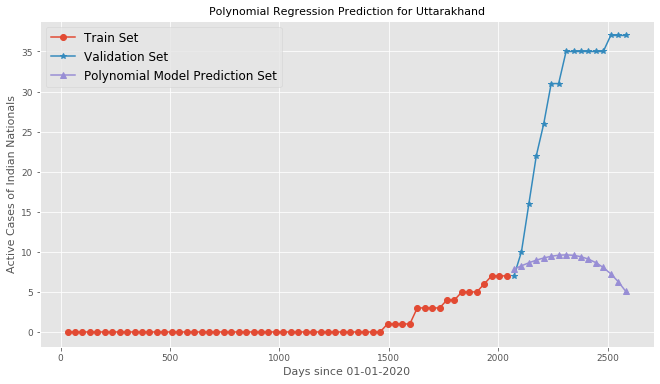

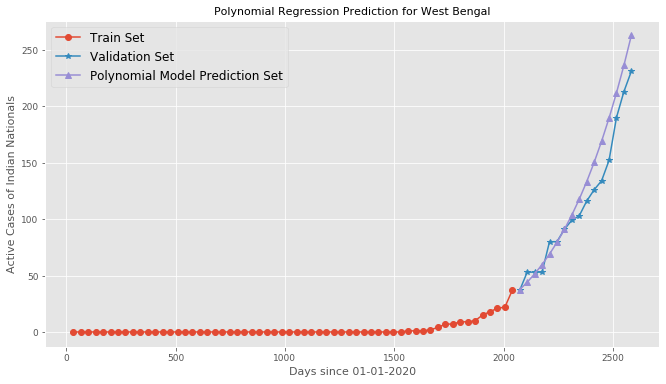

In [16]:
# finding the unique states in the column to analyze further
states = state_date["State/UnionTerritory"]
# insert the list to the set 
unique_states = set(states) 
# convert the set to the list 
unique_states = (list(unique_states))
# sorting the list alphabetically
unique_states = sorted(unique_states)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error

for state in unique_states:
    temp = []
    for ind, i in state_date.iterrows():
        if i["State/UnionTerritory"] == state:
            temp.append(i)
        
    temp = pd.DataFrame(temp)
    temp = temp[["ConfirmedCases", "Days Since"]]
    
    train_ml = temp.iloc[: int(temp.shape[0] * 0.8)]
    valid_ml = temp.iloc[int(temp.shape[0] * 0.8):]
    y_pred = valid_ml.copy()
    
    poly_reg = PolynomialFeatures(degree = 5) 
    X_poly = poly_reg.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
    poly_reg.fit(X_poly, np.array(train_ml["ConfirmedCases"]).reshape(-1,1))
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, np.array(train_ml["ConfirmedCases"]).reshape(-1,1))
    
    # making the predictions
    prediction_valid_polyreg = lin_reg.predict(poly_reg.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1)))
    y_pred["Polynomial Regression Model Prediction"] = list(prediction_valid_polyreg)
    
    # printing the root mean square error
    print("Root Mean Square Error for " + state + "'s Polynomial Regression: ", np.sqrt(mean_squared_error(valid_ml["ConfirmedCases"], prediction_valid_polyreg)))
    
    # plotting the predictions by the model
    plt.figure(figsize = (11, 6))
    plt.plot(train_ml.index, train_ml["ConfirmedCases"], label = "Train Set", marker = 'o')
    plt.plot(valid_ml.index, valid_ml["ConfirmedCases"], label = "Validation Set", marker = '*')
    plt.plot(y_pred["Polynomial Regression Model Prediction"], label = "Polynomial Model Prediction Set", marker = '^')
    plt.legend()
    plt.xlabel("Days since 01-01-2020")
    plt.ylabel("Active Cases of Indian Nationals")
    plt.title("Polynomial Regression Prediction for " + state)
    
# clearing the memory
del unique_states
del states